In [11]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
df = pd.read_csv("../data/feature_1.csv",sep=',')
df['timestamp'] = df.timestamp.apply(lambda x: pd.to_datetime(x))
df.set_index('timestamp',inplace=True,drop=True)

In [3]:
df.head()

,value,label,weekday,day,hour,minute,timestamp_int,pre_1minute,pre_2minute,pre_3minute,pre_4minute,pre_5minute,pre_1day
timestamp,,,,,,,,,,,,,
2017-05-08 04:06:00,2.508197,0,1,8,4,6,1494187560,2.737705,2.918033,3.032787,2.786885,2.918033,2.344262
2017-05-08 04:07:00,2.885246,0,1,8,4,7,1494187620,2.508197,2.737705,2.918033,3.032787,2.786885,2.344262
2017-05-08 04:08:00,2.803279,0,1,8,4,8,1494187680,2.885246,2.508197,2.737705,2.918033,3.032787,2.524590
2017-05-08 04:09:00,2.868852,0,1,8,4,9,1494187740,2.803279,2.885246,2.508197,2.737705,2.918033,2.409836
2017-05-08 04:10:00,2.770492,0,1,8,4,10,1494187800,2.868852,2.803279,2.885246,2.508197,2.737705,2.606557


In [14]:
feature_df = df[df.columns[-6:].values]
feature_df['value'] = df.value
feature_df.head()

,pre_1minute,pre_2minute,pre_3minute,pre_4minute,pre_5minute,pre_1day,value
timestamp,,,,,,,
2017-05-08 04:06:00,2.737705,2.918033,3.032787,2.786885,2.918033,2.344262,2.508197
2017-05-08 04:07:00,2.508197,2.737705,2.918033,3.032787,2.786885,2.344262,2.885246
2017-05-08 04:08:00,2.885246,2.508197,2.737705,2.918033,3.032787,2.524590,2.803279
2017-05-08 04:09:00,2.803279,2.885246,2.508197,2.737705,2.918033,2.409836,2.868852
2017-05-08 04:10:00,2.868852,2.803279,2.885246,2.508197,2.737705,2.606557,2.770492


In [32]:
def scale(train,test):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)
    return scaler,scaled_train,scaled_test

def reshape_data(train_scaled,test_scaled):
    train_x = train_scaled[:,:-1]
    train_y = train_scaled[:,-1]
    test_x = test_scaled[:, :-1]
    test_y = test_scaled[:,-1]
    # reshape input to be 3D [samples, timesteps, features]
    train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])
    return train_x,train_y,test_x,test_y

In [33]:
train = feature_df[:67*24*60]
test = feature_df[67*24*60:]
scaler,train_scaled,test_scaled = scale(train,test)
train_x,train_y,test_x,test_y = reshape_data(train_scaled,test_scaled)

In [45]:
def fit_LSTM(train_x, train_y, batch_size, epoch, neurons):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size,train_x.shape[1],train_x.shape[2]),stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    for i in range(epoch):
        model.fit(train_x,train_y,epochs=1,batch_size=batch_size,verbose=0,shuffle=False)
        model.reset_states()
    return model

In [57]:
lstm_model = fit_LSTM(train_x,train_y, 1, 5, 4)

In [76]:
lstm_model.predict(train_x, batch_size=1)

array([[ 0.25246215],
       [ 0.18723989],
       [ 0.3816002 ],
       ..., 
       [ 0.11921132],
       [ 0.14031833],
       [ 0.09388959]], dtype=float32)

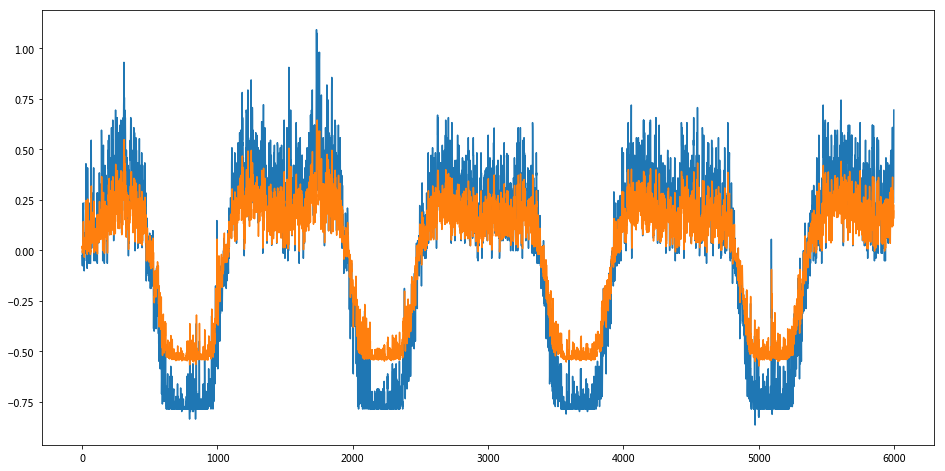

In [77]:
size = 6000
a = lstm_model.predict(test_x[:size], batch_size=1)
c = a.reshape(size,)
b = test_y[:size]
plt.figure(figsize=(16,8))
plt.plot(b)
plt.plot(c)

plt.show()